In [1]:
'''
Install Modules (Windows CPU version)
'''

!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html 


Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
'''
import modules
'''

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [3]:
'''
Dataset class 정의
'''

class ShoppingDataset(Dataset):
    performance_path = 'C:/Users/lhy92/Downloads/01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터.xlsx'
    # ratings는 현재 고려하지 않았습니다.
    ratings_path = 'C:/Users/lhy92/Downloads/01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx'

    def __init__(self, train=True, transforms=None):
        performance = pd.read_excel(self.performance_path)
        #ratings = pd.read_excel(self.ratings_path)

        # 다음 comment 전가지는 전처리2.ipynb의 내용과 많이 유사합니다.
        performance.columns=['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액']
        performance = performance.drop([0])
        performance = performance.fillna(0)

        encoder = LabelEncoder()

        items = performance['상품명']
        encoder.fit(items)
        performance['상품명'] = encoder.transform(items)

        items = performance['상품군']
        encoder.fit(items)
        performance['상품군'] = encoder.transform(items)


        # 11월이전과 이후로 train과 val을 구분하였습니다.
        train_performance = performance[performance['방송일시'] < pd.Timestamp(2019, 11, 1)]
        train_performance['방송일시'] = pd.to_numeric(train_performance['방송일시'], downcast='float')
        train_performance = train_performance.to_numpy().astype('float32')

        val_performance = performance[performance['방송일시'] >= pd.Timestamp(2019, 11, 1)]
        val_performance['방송일시'] = pd.to_numeric(val_performance['방송일시'], downcast='float')
        val_performance = val_performance.to_numpy().astype('float32')
        

        # 값들 간의 차이가 너무 커 train dataset을 기준으로 정규분포로 만들었습니다.
        mean = np.mean(train_performance, axis=0, keepdims=True)
        std = np.std(train_performance, axis=0, keepdims=True)

        # target 값은 train dataset을 기준으로 최소값이 0, 최대값이 1이 되도록 하였습니다.
        # SimpleNN 에서도 마지막 부분을 sigmoid로 하였습니다.
        # 여기서 train dataset의 최대 취급액보다 높은 경우는 존재하지 않을 것이라 가정하였습니다.
        target_min = np.min(train_performance[:, -1:])
        target_max = np.max(train_performance[:, -1:])

        if train:
            performance = train_performance
        else:
            performance = val_performance
        
        self.inputs = (performance[:, :-1] - mean[:, :-1]) / std[:, :-1]
        self.targets = (performance[:, -1:] - target_min) / (target_max - target_min)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input = torch.FloatTensor(self.inputs[idx])
        target = torch.FloatTensor(self.targets[idx])
        return input, target

In [4]:
'''
DataLoader 준비
'''
batch_size = 128

train_dataset = ShoppingDataset(train=True)
val_dataset = ShoppingDataset(train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
'''
Create Model
'''

class SimpleNN(nn.Module):
    def __init__(self, in_features=7):
        super(SimpleNN, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.features(x)

model = SimpleNN()

In [6]:
'''
Loss function과 optimizer 정의
'''
lr = 0.1
momentum=0.9
wd = 1e-4

# 참고로 learning rate를 조절하는 부분에 대해서는 구현을 하지 않은 것입니다.

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, weight_decay=wd)

In [7]:
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0

    # Train
    model.train()
    for i, (inputs, target) in enumerate(train_loader):
        # Compute output
        output = model(inputs)
        loss = criterion(output, target)

        # Compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= (len(train_loader)/batch_size)
    train_losses.append(train_loss)
    
    # Val
    model.eval()
    with torch.no_grad():
        for i, (inputs, target) in enumerate(val_loader):
            # Compute output
            output = model(inputs)
            loss = criterion(output, target)

            val_loss += loss.item()
    val_loss /= (len(val_loader)/batch_size)
    val_losses.append(val_loss)

    print('Epochs: {}, Train Loss: {}, Val Loss: {}'.format(epoch, train_loss, val_loss))



Epochs: 0, Train Loss: 3.105413624218532, Val Loss: 4.932704478502274
Epochs: 1, Train Loss: 2.9917217951918404, Val Loss: 4.910915156205495
Epochs: 2, Train Loss: 1.606936248995009, Val Loss: 2.295483267555634
Epochs: 3, Train Loss: 1.1008956784766817, Val Loss: 2.3650286495685577
Epochs: 4, Train Loss: 1.044430039704792, Val Loss: 2.2152784603337445
Epochs: 5, Train Loss: 1.0148424395020046, Val Loss: 2.1759048302968345
Epochs: 6, Train Loss: 0.9950467560972486, Val Loss: 2.177231192588806
Epochs: 7, Train Loss: 0.9744685592632445, Val Loss: 2.2346230099598565
Epochs: 8, Train Loss: 0.9647255028997149, Val Loss: 2.1213531444470086
Epochs: 9, Train Loss: 0.955768858156507, Val Loss: 2.120174060265223
Epochs: 10, Train Loss: 0.9395016751119069, Val Loss: 2.1316865732272468
Epochs: 11, Train Loss: 0.9316378408481204, Val Loss: 2.1166314805547395
Epochs: 12, Train Loss: 0.9278456226937355, Val Loss: 2.1076520420610905
Epochs: 13, Train Loss: 0.916658024466227, Val Loss: 2.160102489093939

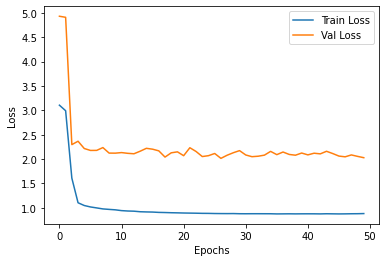

In [8]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'])
plt.show()